In [1]:
import os, sys, path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from bbox import BBox2D, XYWH
from bbox.metrics import jaccard_index_2d

import visual_genome_python_driver.src.local as vg
VG_path = "/projectnb/llamagrp/shawnlin/ref-exp-gen/dataset/visual_genome/raw_zip/test/"

# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300

In [82]:
# sys.path.append("/projectnb/llamagrp/shawnlin/ref-exp-gen/refer")

from refer.refer import REFER
import numpy as np
import skimage.io as io

dataroot = "/projectnb/llamagrp/shawnlin/ref-exp-gen/ref-analysis/refer/data"
dataset = "refcoco"
refer = REFER(dataroot, dataset, "google")

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=8.34s)


In [2]:
# # Only execute this block for the first time.

# # scene_graph.json takes up to 1.4G on disk.
# vg.AddAttrsToSceneGraphs(VG_path)

# # It generates the scene_graph json file for all Visual Genome images
# vg.SaveSceneGraphsById(dataDir=VG_path, imageDataDir=VG_path+"/by-id/")
# print("Scene graph process done!!")

In [3]:
game_data = pd.read_csv("./data/out_filtered_with_matching_noboxarounds.csv")
condition_map = {'double_max': 2,
                 'double_min': 2,
                 'single_max': 1,
                 'single_min': 1,
                 'triple_max': 3,
                 'triple_min': 3}
game_data["distractors"] = game_data["image_condition"].apply(lambda x: condition_map[x])
# game_data

In [4]:
game_data["image_id"]

0      2358094
1      2355115
2      2322637
3      2359982
4      2384732
        ...   
291    2359029
292    2355115
293    2397606
294    2342953
295    2372681
Name: image_id, Length: 296, dtype: int64

In [5]:
# Retrieve scene graphs
image_ids = list(set(game_data["image_id"]))
scene_graphs = vg.GetSceneGraphsByIds(imageIds=image_ids, minRels=0,
                                      dataDir=VG_path, imageDataDir=VG_path+'by-id/')

print("Total images in game_data: %i" % (len(scene_graphs)))

Total images in game_data: 136


In [8]:
# Calculate refcoco and visual-genome intersection
match_cnt = 0

for i, image_id in enumerate(image_ids):
    graph = scene_graphs[image_id]
    image = graph.image
    if image.coco_id is not None:
        ref_id = image.coco_id
        if ref_id not in refer.Refs:
            continue
        else:
            ref = refer.Refs[ref_id]
        
        ref_exprs = ref["sentences"]
        for sent in ref_exprs:
            print(sent["raw"])
        #print('ref_id [%s] (ann_id [%s])' % (ref_id, refer.refToAnn[ref_id]['id']))
        match_cnt += 1
        # show the segmentation of the referred object
        #plt.figure()
        #refer.showRef(ref, seg_box='seg')
        #plt.show()

print("Total matches: %.3f(%i/%i)" % (float(match_cnt)/len(image_ids), match_cnt, len(image_ids)))

the shortest baseball player
short guy
shortest player
clock 1019
10:19
10:19
greenish jacket
manin green jacket
lighter blue hat
Lady
woman
woman
little boy
kid
Baby in highchair
Total matches: 0.037(5/136)


In [10]:
vg_image_data = vg.GetAllImageData(VG_path)
len(vg_image_data)

108077

In [11]:
oov_images = [v for v in vg_image_data if v.coco_id is None and v.flickr_id is None]
coco_images = [v for v in vg_image_data if v.coco_id is not None]
flickr_images = [v for v in vg_image_data if v.flickr_id is not None and v.coco_id is None]
    
print("oov image: %i\ncoco image: %i\nflickr image: %i" % (len(oov_images), len(coco_images), len(flickr_images)))

oov image: 5000
coco image: 51498
flickr image: 51579


In [83]:
ref_image_data = list(refer.Imgs.values())
len(ref_image_data)
print(ref_image_data[0])
print(coco_images[0])

{'license': 1, 'file_name': 'COCO_train2014_000000098304.jpg', 'coco_url': 'http://mscoco.org/images/98304', 'height': 424, 'width': 640, 'date_captured': '2013-11-21 23:06:41', 'flickr_url': 'http://farm6.staticflickr.com/5062/5896644212_a326e96ea9_z.jpg', 'id': 98304}
id: 2415074, coco_id: 33554, flickr_id: 128827281, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2415074.jpg


In [84]:
vg_coco_image_ids = {v.coco_id: v for v in coco_images}
test_exprs = {}
match_cnt = 0
for data in ref_image_data:
    if data["id"] in vg_coco_image_ids:
        match_cnt += 1
        refs = refer.imgToRefs[data["id"]]
        img_url = str(vg_coco_image_ids[data["id"]].url)
        for ref in refs:
            #print(ref["file_name"])
            assert(type(ref["category_id"]) == int)
            obj_type = refer.loadCats(ref["category_id"])[0]
            sentences = ref["sentences"]
            for s in sentences:
                test_exprs[s["sent"]] = (obj_type, img_url)
                # print(s["sent"], "-->", obj_type, vg_coco_image_ids[data["id"]].url)
#         break#input()
print(len(test_exprs))
print(match_cnt)

33348
7864


In [85]:
with open("./test_expr.txt", "w+") as f:
    for sent, tup in list(test_exprs.items()):
        f.write("%s\t%s\t%s\n" % (sent, tup[0], tup[1]))

In [24]:
vg_image_data[-10:]

[id: 2417987, coco_id: -1, flickr_id: 9402423191, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417987.jpg,
 id: 2417988, coco_id: 15751, flickr_id: 9419515091, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417988.jpg,
 id: 2417989, coco_id: -1, flickr_id: 9457628691, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417989.jpg,
 id: 2417990, coco_id: -1, flickr_id: 9536592891, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417990.jpg,
 id: 2417991, coco_id: 560819, flickr_id: 9650692891, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417991.jpg,
 id: 2417992, coco_id: 41116, flickr_id: 9669763691, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417992.jpg,
 id: 2417993, coco_id: 109761, flickr_id: 9680535991, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417993.jpg,
 id: 2417994, coco_id: 27438, flickr_id: 9684712191, width: 500, url: https://cs.stanford.

1. little boy
2. kid
3. baby in highchair


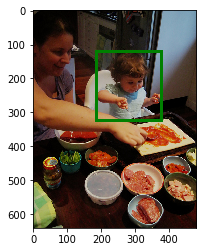

Category: person


{'sent_ids': [121565, 121566, 121567],
 'file_name': 'COCO_train2014_000000080931_14.jpg',
 'ann_id': 1737209,
 'ref_id': 42785,
 'image_id': 80931,
 'split': 'train',
 'sentences': [{'tokens': ['little', 'boy'],
   'raw': 'little boy',
   'sent_id': 121565,
   'sent': 'little boy'},
  {'tokens': ['kid'], 'raw': 'kid', 'sent_id': 121566, 'sent': 'kid'},
  {'tokens': ['baby', 'in', 'highchair'],
   'raw': 'Baby in highchair',
   'sent_id': 121567,
   'sent': 'baby in highchair'}],
 'category_id': 1}

In [82]:
ref = refer.Refs[42785]

plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()
print("Category:", refer.Cats[ref["category_id"]])
ref

In [83]:
refer.Cats

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [8]:
%%time
reg_desc = vg.GetAllRegionDescriptionsByIds(VG_path, image_ids)

CPU times: user 9.68 s, sys: 2.47 s, total: 12.2 s
Wall time: 14.1 s


In [8]:
import matplotlib.image as mpimg

"""
Pair the bounding boxes with the one with maximum IoU
"""
def merge_object_boxes(image_id, scene_graph, speaker_bbox, listener_bbox, debug=False):

    if debug:
        image_path = "%s/VG_100K/%i.jpg" % (VG_path, image_id)
        if not os.path.exists(image_path):
            image_path = "%s/VG_100K_2/%i.jpg" % (VG_path, image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

    if debug:
        ax = plt.gca()
        rect = patches.Rectangle((speaker_bbox.x1, speaker_bbox.y1),
                                 speaker_bbox.width,
                                 speaker_bbox.height,
                                 linewidth=2, edgecolor='lawngreen', facecolor='none')
        ax.add_patch(rect)
        rect = patches.Rectangle((listener_bbox.x1, listener_bbox.y1),
                                 listener_bbox.width,
                                 listener_bbox.height,
                                 linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    max_obj = None
    max_iou = -1.0
    for obj in scene_graph.objects:
        
        iou = jaccard_index_2d(obj.bbox, speaker_bbox)
        if iou > max_iou and iou > 0.799:
            max_obj = obj
            max_iou = iou

    if debug and max_obj is not None:
        rect = patches.Rectangle((max_obj.bbox.x1, max_obj.bbox.y1),
                                 max_obj.bbox.width,
                                 max_obj.bbox.height,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.show()

    return max_obj

def merge_region_descs_hq(fn, regions, speaker_bbox, listener_bbox, debug=False):
    
    if debug:
        img = mpimg.imread(fn)
#         img = cv2.imread(fn)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    
    if debug:
        ax = plt.gca()
        rect = patches.Rectangle((speaker_bbox.x1, speaker_bbox.y1),
                                 speaker_bbox.width,
                                 speaker_bbox.height,
                                 linewidth=2, edgecolor='lawngreen', facecolor='none')
        ax.add_patch(rect)
        
    max_region = None
    max_iou = -1.0
    for region in regions:
        iou = jaccard_index_2d(region.bbox, speaker_bbox)
        if iou > max_iou and iou > 0.799:
            max_region = region
            max_iou = iou

    plt.axis('off')
    plt.savefig(fn.replace(".jpg", "")+"_bbox.png", bbox_inches=0)
    plt.show()
#     input()

    return max_region

def merge_region_descs(image_id, regions, speaker_bbox, listener_bbox, debug=False):

    if jaccard_index_2d(speaker_bbox, listener_bbox) < 0.8:
        return None
    
    if debug:
        image_path = "%s/VG_100K/%i.jpg" % (VG_path, image_id)
        if not os.path.exists(image_path):
            image_path = "%s/VG_100K_2/%i.jpg" % (VG_path, image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

    if debug:
        ax = plt.gca()
        rect = patches.Rectangle((speaker_bbox.x1, speaker_bbox.y1),
                                 speaker_bbox.width,
                                 speaker_bbox.height,
                                 linewidth=2, edgecolor='lawngreen', facecolor='none')
        ax.add_patch(rect)
        rect = patches.Rectangle((listener_bbox.x1, listener_bbox.y1),
                                 listener_bbox.width,
                                 listener_bbox.height,
                                 linewidth=5, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    max_region = None
    max_iou = -1.0
    for region in regions:
        
        iou = jaccard_index_2d(region.bbox, speaker_bbox)
        if iou > max_iou and iou > 0.799:
            max_region = region
            max_iou = iou
#     plt.show()
    if debug and max_region is not None:
        rect = patches.Rectangle((max_region.bbox.x1, max_region.bbox.y1),
                                 max_region.bbox.width,
                                 max_region.bbox.height,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.show()
#     print(max_iou)
    return max_region


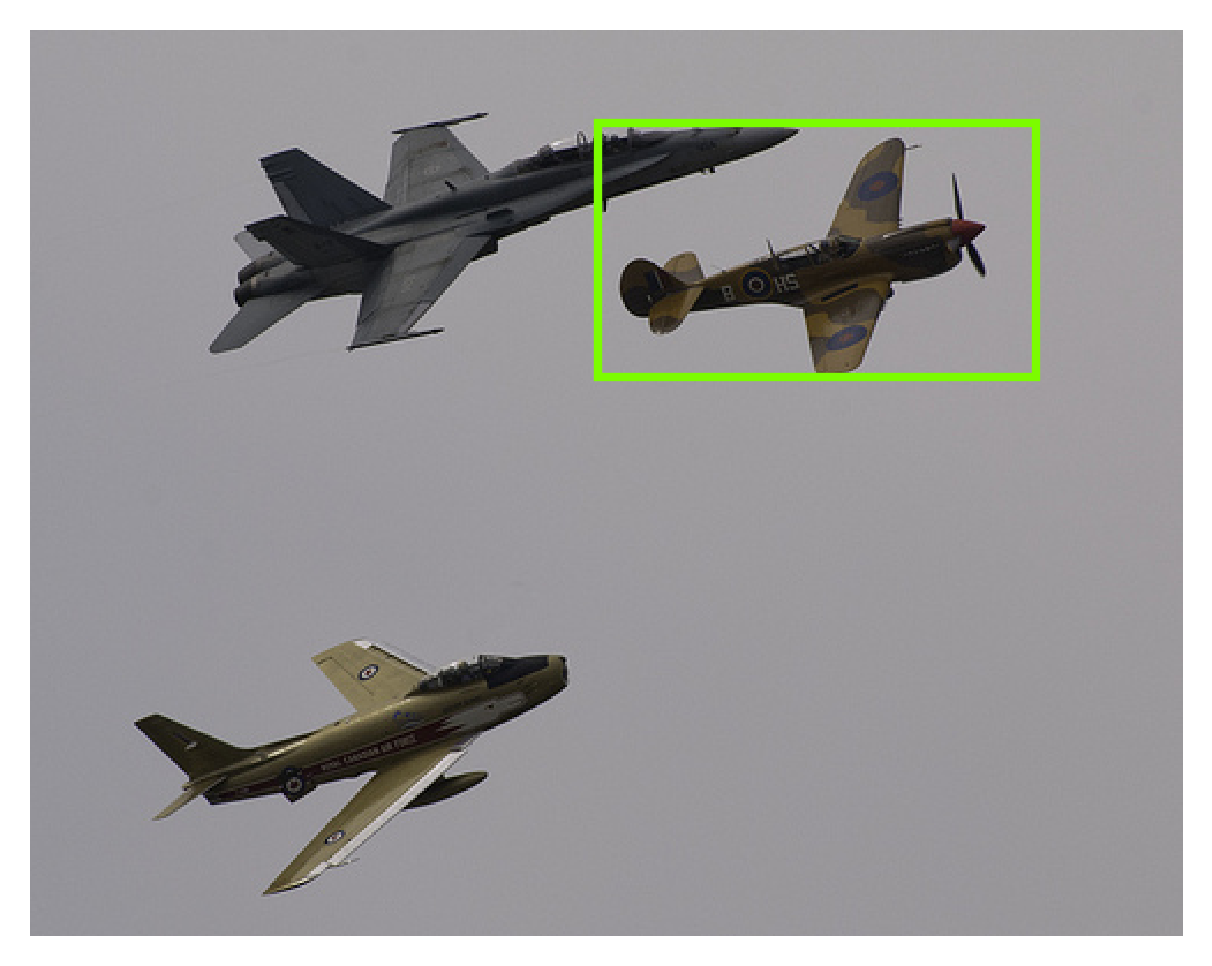

Imgid: 2410084, Obj: None, Distractors: 3, 
	Region desc: 'Plane with a propeller on the front' 
	Speaker_msg: 'the airplane in the middle'


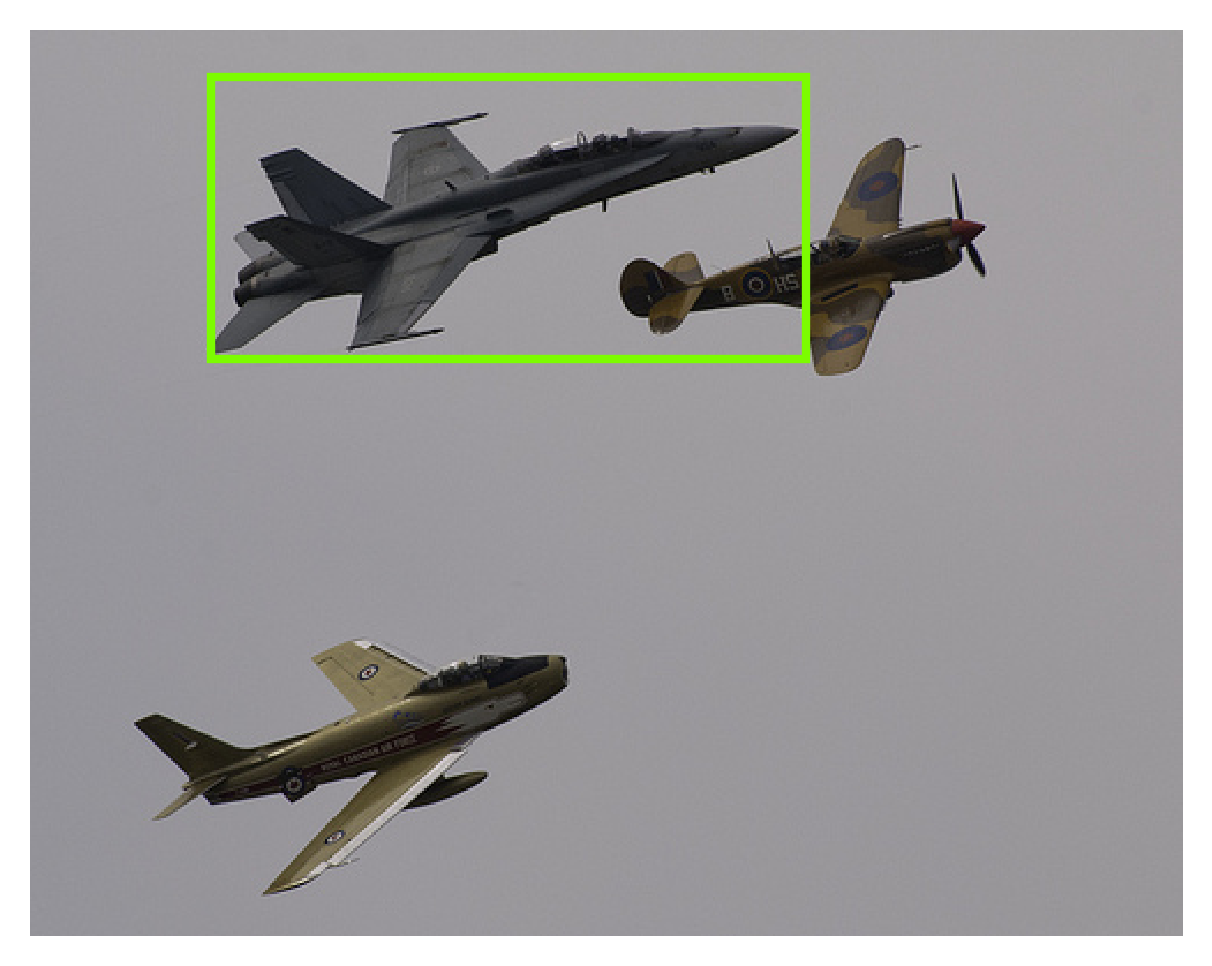

Imgid: 2410084, Obj: None, Distractors: 3, 
	Region desc: 'the plane is the biggest' 
	Speaker_msg: 'the grey plane'


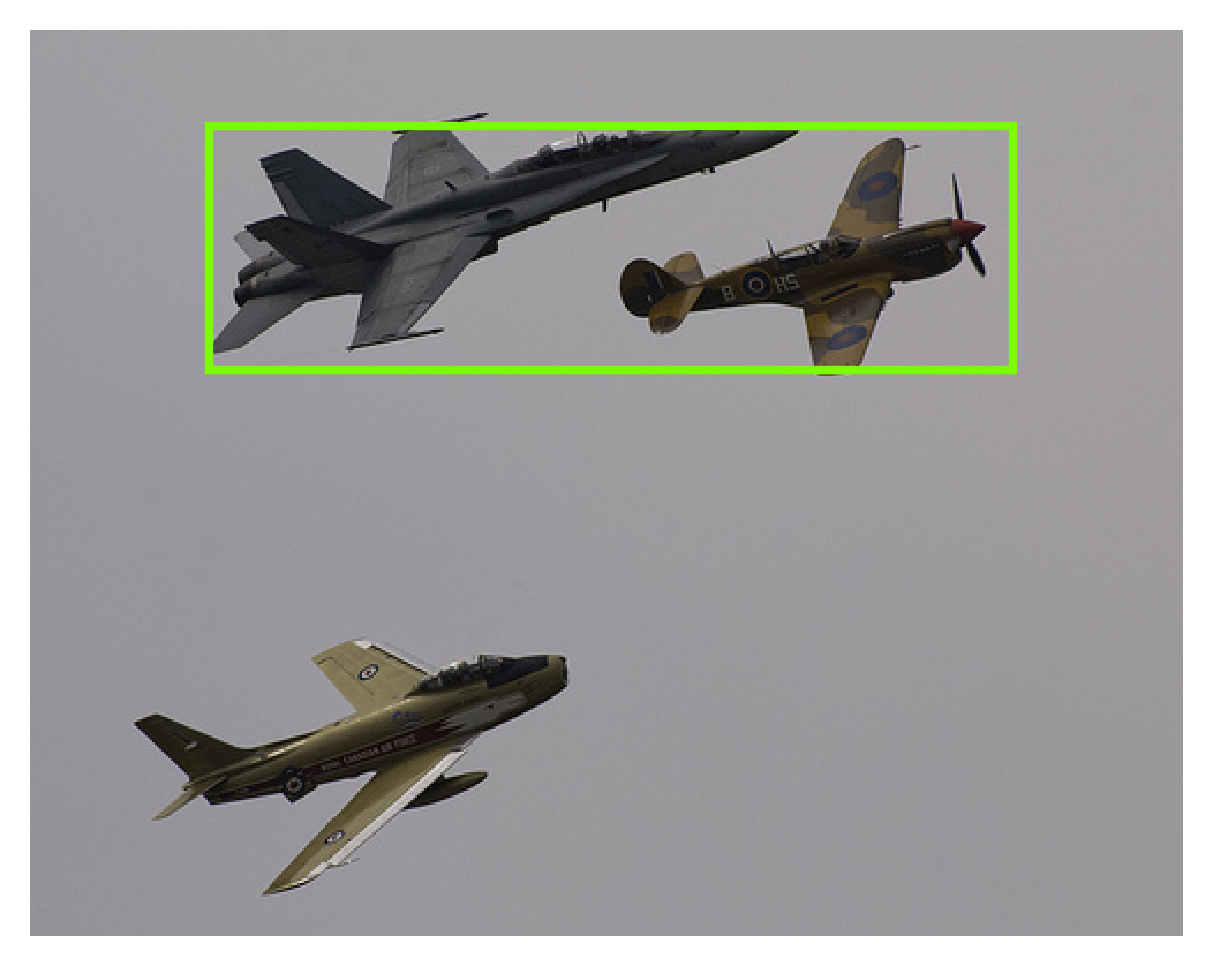

Imgid: 2410084, Obj: None, Distractors: 3, 
	Region desc: 'Two planes on the same level' 
	Speaker_msg: 'jet'


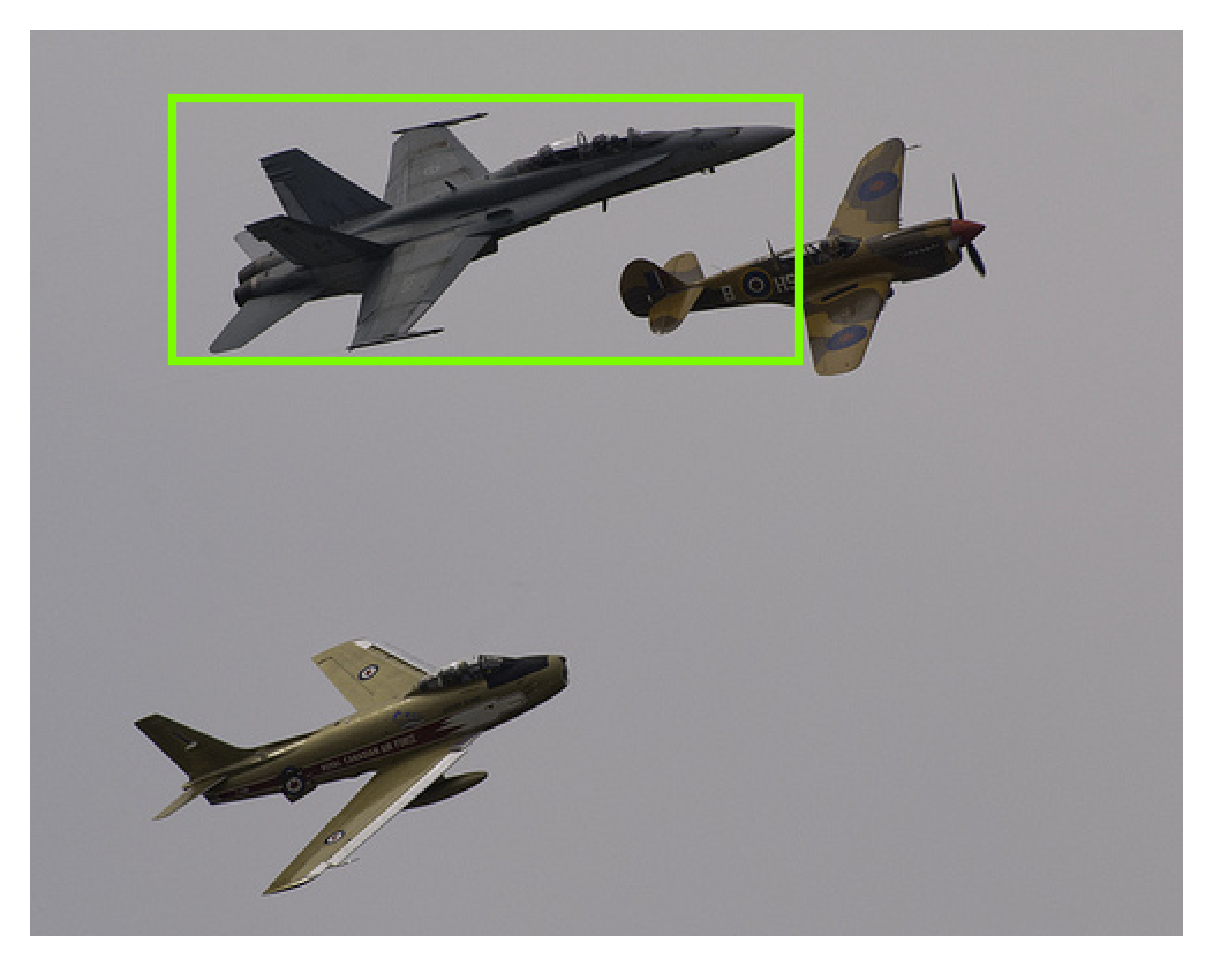

Imgid: 2410084, Obj: None, Distractors: 3, 
	Region desc: 'a plane in the sky ' 
	Speaker_msg: 'The large grey plane'


In [43]:
img_id = 2410084

for i, (index, row) in enumerate(game_data[game_data["image_id"] == img_id].iterrows()):
    #if i > 20: break
    
    speaker_bbox = BBox2D([row["speaker_bbox_x"],
                           row["speaker_bbox_y"],
                           row["speaker_bbox_width"],
                           row["speaker_bbox_height"]], mode=XYWH)
    listener_bbox = BBox2D([row["listener_bbox_x"],
                            row["listener_bbox_y"],
                            row["listener_bbox_width"],
                            row["listener_bbox_height"]], mode=XYWH)
    
    spkr_msg = row["speaker_messages"]
    n_distractors = row["distractors"]
    image_id = row["image_id"]
    
    region = merge_region_descs_hq("data/planes.jpg", reg_desc[image_id], listener_bbox, speaker_bbox, True)
    if debug:
        obj_name = "None"
        print("Imgid: %i, Obj: %s, Distractors: %i, \n\tRegion desc: '%s' \n\tSpeaker_msg: '%s'" % (image_id, obj_name, n_distractors, region.phrase, spkr_msg))


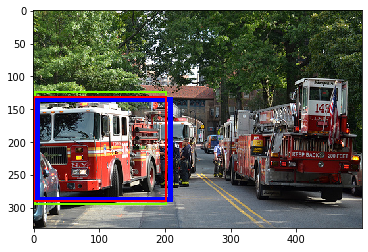

Imgid: 2349826, Obj: truck, Distractors: 3, 
	Region desc: 'red fire engine' 
	Speaker_msg: 'fire truck facing forward'


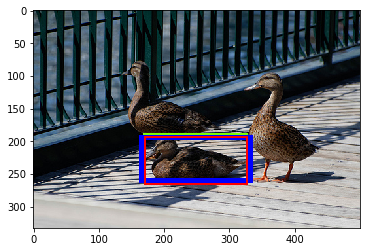

Imgid: 2372681, Obj: duck, Distractors: 3, 
	Region desc: 'A duck lying on a boardwalk' 
	Speaker_msg: 'sitting duck'


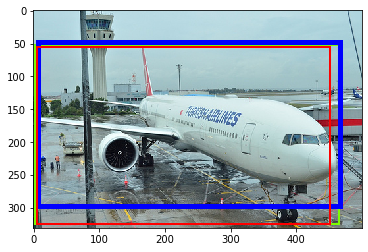

Imgid: 2352193, Obj: plane, Distractors: 3, 
	Region desc: 'A large red and white airplane' 
	Speaker_msg: 'the plane'


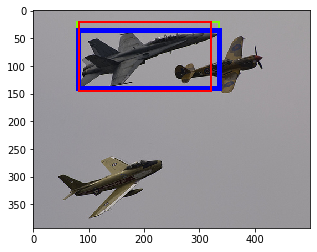

Imgid: 2410084, Obj: plane, Distractors: 3, 
	Region desc: 'the plane is the biggest' 
	Speaker_msg: 'the grey plane'


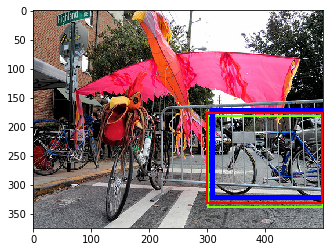

Imgid: 2333857, Obj: bicycle, Distractors: 3, 
	Region desc: 'A bicycle by the bicycle rack' 
	Speaker_msg: 'the blue bike with the water bottle on it'


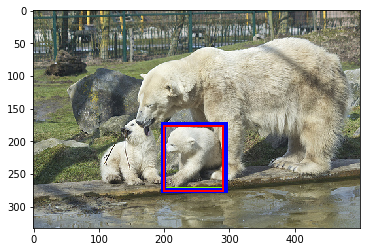

Imgid: 2370467, Obj: bear cub, Distractors: 3, 
	Region desc: 'a little baby polar bear' 
	Speaker_msg: 'the bear that's not getting licked'


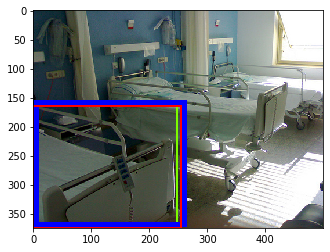

Imgid: 2331207, Obj: None, Distractors: 3, 
	Region desc: 'hospital bed is empty' 
	Speaker_msg: 'the closest bed'


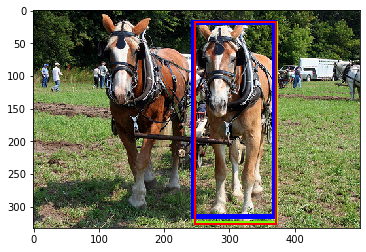

Imgid: 2328683, Obj: horse, Distractors: 3, 
	Region desc: 'A tan and white horse.' 
	Speaker_msg: 'the horse closest to the background truck'


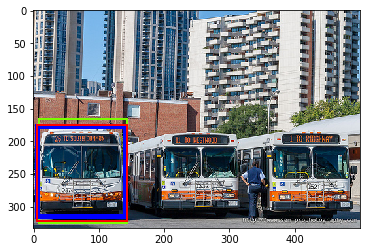

Imgid: 2407105, Obj: bus, Distractors: 3, 
	Region desc: 'bus to South Common' 
	Speaker_msg: '26 to south common bus'


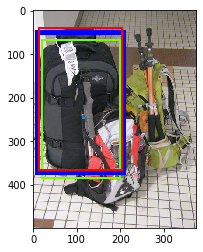

Imgid: 2342953, Obj: bag, Distractors: 3, 
	Region desc: 'the black backpack is full sitting on the floor' 
	Speaker_msg: 'Black backpack'


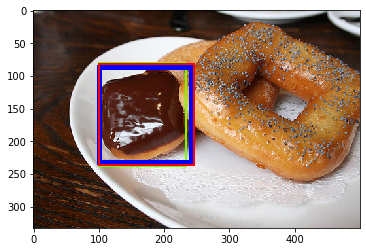

Imgid: 2327534, Obj: None, Distractors: 3, 
	Region desc: 'a chocolate donut on a white plate' 
	Speaker_msg: 'the food with chocolate on it'


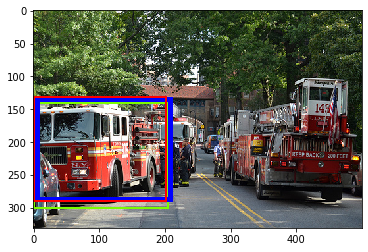

Imgid: 2349826, Obj: truck, Distractors: 3, 
	Region desc: 'red fire engine' 
	Speaker_msg: 'the big red vehicle on the left'


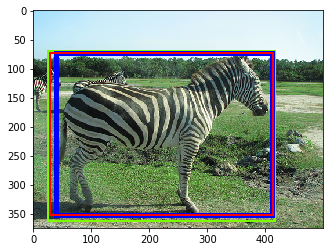

Imgid: 2334039, Obj: zebra, Distractors: 3, 
	Region desc: 'Zebra on the ground.' 
	Speaker_msg: 'zebra'


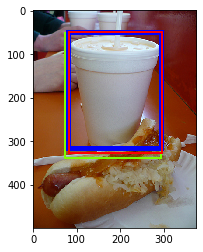

Imgid: 2385890, Obj: styrofoam cup, Distractors: 3, 
	Region desc: 'a white cup with a straw' 
	Speaker_msg: 'cup'


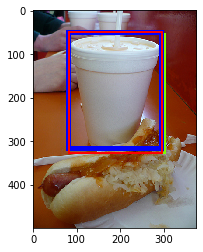

Imgid: 2385890, Obj: styrofoam cup, Distractors: 3, 
	Region desc: 'a white cup with a straw' 
	Speaker_msg: 'The cup behind the Hot Dog'


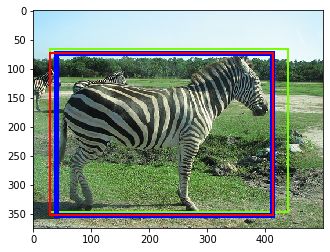

Imgid: 2334039, Obj: zebra, Distractors: 3, 
	Region desc: 'Zebra on the ground.' 
	Speaker_msg: 'The closest Zebra to the camera'


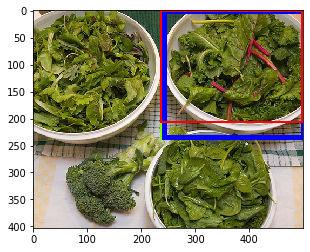

Imgid: 2388621, Obj: None, Distractors: 3, 
	Region desc: 'this bowl is filled with green leaves of lettice' 
	Speaker_msg: 'The bowl that has some red in it'


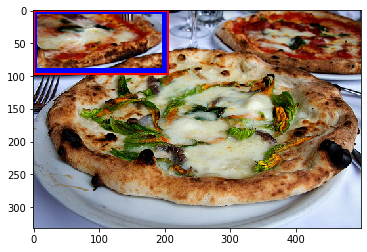

Imgid: 2358777, Obj: pizza, Distractors: 3, 
	Region desc: 'whole pizza on white plate' 
	Speaker_msg: 'The left pizza'


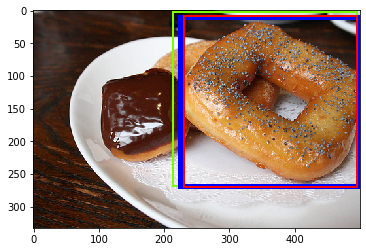

Imgid: 2327534, Obj: rectangle donut, Distractors: 3, 
	Region desc: 'rectangle shaped sprinkle donut' 
	Speaker_msg: 'the donut with the seeds on it on top'


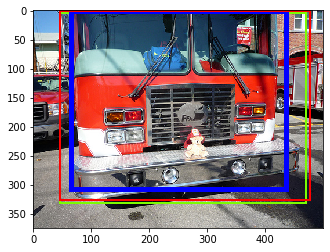

Imgid: 2397049, Obj: truck, Distractors: 3, 
	Region desc: 'A fire truck.' 
	Speaker_msg: 'the fire truck'


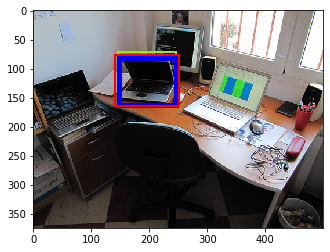

Imgid: 2350331, Obj: computer, Distractors: 3, 
	Region desc: 'half closed laptop sitting on desk' 
	Speaker_msg: 'the middle laptop'


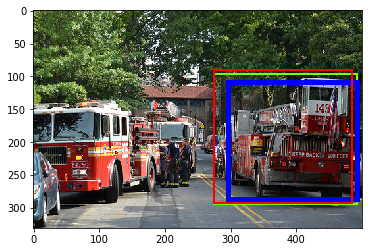

Imgid: 2349826, Obj: fire engine, Distractors: 3, 
	Region desc: 'fire truck with ladder' 
	Speaker_msg: 'the right read fire truck'


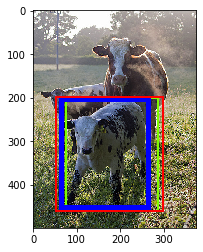

Imgid: 2374643, Obj: calf, Distractors: 3, 
	Region desc: 'white cow with black speckles' 
	Speaker_msg: 'the cow'


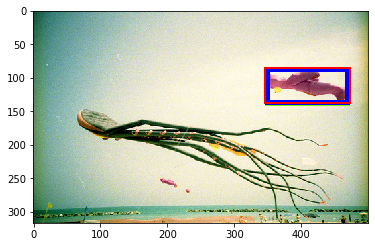

Imgid: 2388767, Obj: None, Distractors: 3, 
	Region desc: 'a purple bear is in the background' 
	Speaker_msg: 'draw a box for the pink color toy::yellow color in mouth pink toy'


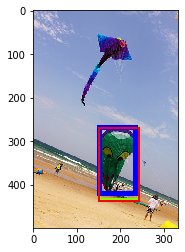

Imgid: 2326909, Obj: kite, Distractors: 3, 
	Region desc: 'This kite is huge' 
	Speaker_msg: 'Draw box for the green color kite'


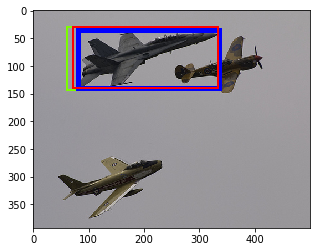

Imgid: 2410084, Obj: plane, Distractors: 3, 
	Region desc: 'a plane in the sky ' 
	Speaker_msg: 'The large grey plane'


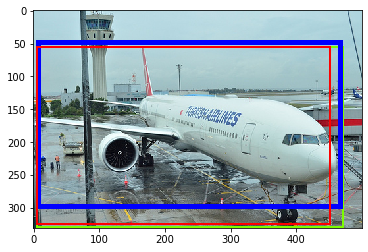

Imgid: 2352193, Obj: plane, Distractors: 3, 
	Region desc: 'A large red and white airplane' 
	Speaker_msg: 'The entire plane to include wings'


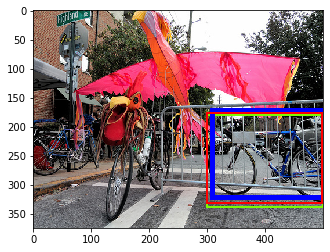

Imgid: 2333857, Obj: bicycle, Distractors: 3, 
	Region desc: 'A bicycle by the bicycle rack' 
	Speaker_msg: 'The blue bicycle behind the rack'


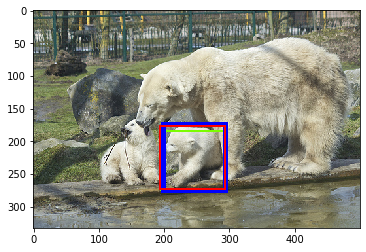

Imgid: 2370467, Obj: bear cub, Distractors: 3, 
	Region desc: 'a polar bear cub' 
	Speaker_msg: 'The small bear that is underneath the mom's chin<comma> not being licked'


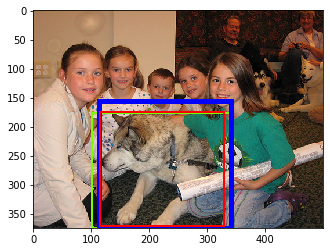

Imgid: 2333590, Obj: None, Distractors: 3, 
	Region desc: 'large grey and white husky' 
	Speaker_msg: 'the Dog in the middle::Center dog I mean'


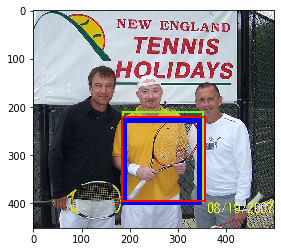

Imgid: 2337654, Obj: racket, Distractors: 3, 
	Region desc: 'a red and black racket' 
	Speaker_msg: 'Center guy racket'


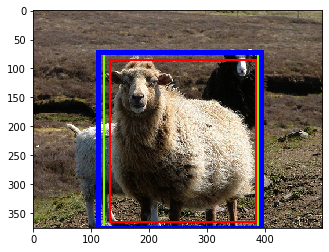

Imgid: 2403170, Obj: sheep, Distractors: 3, 
	Region desc: 'A brown sheep stands in the dirt' 
	Speaker_msg: 'center sheep'


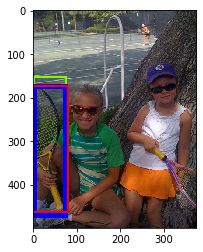

Imgid: 2333917, Obj: racket, Distractors: 3, 
	Region desc: 'A yellow and black tennis racket. ' 
	Speaker_msg: 'BOY RACKET::DRAW BOX FOR BOY RACKET'


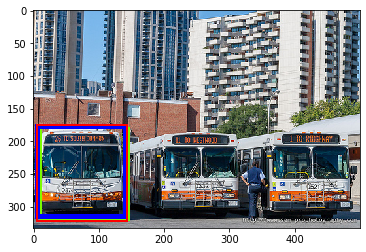

Imgid: 2407105, Obj: bus, Distractors: 3, 
	Region desc: 'bus to South Common' 
	Speaker_msg: 'the bus that says "26 to south common"'


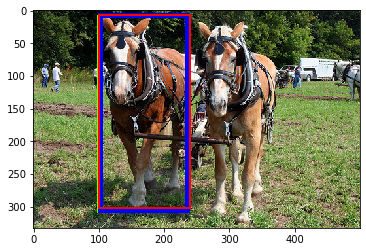

Imgid: 2328683, Obj: horse, Distractors: 3, 
	Region desc: 'large brown hairy horse' 
	Speaker_msg: 'the darker brown horse'


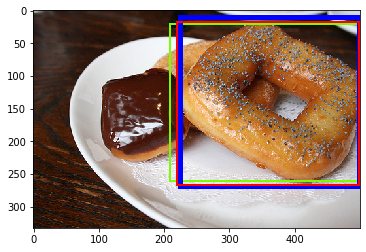

Imgid: 2327534, Obj: rectangle donut, Distractors: 3, 
	Region desc: 'a pastry in the shape of a square' 
	Speaker_msg: 'cake'


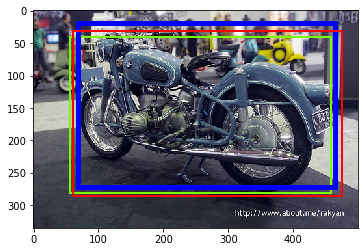

Imgid: 2365085, Obj: motorcycle, Distractors: 3, 
	Region desc: 'a blue BMW motorcycle' 
	Speaker_msg: 'super bike'


<Figure size 432x288 with 0 Axes>

In [9]:
# distractor_cnt = []
# obj_desc_cnt = []
# spkr_msg_cnt = []
data = pd.DataFrame(columns=["n_dist", "obj_desc_len", "spkr_msg_len"])
region_descs = []
for i, (index, row) in enumerate(game_data.iterrows()):
    #if i > 20: break
    
    speaker_bbox = BBox2D([row["speaker_bbox_x"],
                           row["speaker_bbox_y"],
                           row["speaker_bbox_width"],
                           row["speaker_bbox_height"]], mode=XYWH)
    listener_bbox = BBox2D([row["listener_bbox_x"],
                            row["listener_bbox_y"],
                            row["listener_bbox_width"],
                            row["listener_bbox_height"]], mode=XYWH)
    
    spkr_msg = row["speaker_messages"]
    n_distractors = row["distractors"]
    image_id = row["image_id"]
    debug = False
    
    if n_distractors == 3:
        debug = True
    
    obj = merge_object_boxes(image_id, scene_graphs[image_id], speaker_bbox, listener_bbox, False)
    region = merge_region_descs(image_id, reg_desc[image_id], listener_bbox, speaker_bbox, debug)
    if region is None:
        plt.clf()
        region_descs.append("")
        continue
    else:
        region_descs.append(region.phrase)

    data.loc[i] = [n_distractors, len(region.phrase.split()), len(spkr_msg.split())]
    if debug:
        obj_name = obj.names[0] if obj is not None else "None"
        print("Imgid: %i, Obj: %s, Distractors: %i, \n\tRegion desc: '%s' \n\tSpeaker_msg: '%s'" % (image_id, obj_name, n_distractors, region.phrase, spkr_msg))
game_data["region_desc"] = region_descs

In [11]:
game_data.to_csv("game_data.csv", sep=",")
print(len(game_data))

game_data_cleaned = game_data[game_data["region_desc"] != ""]
print(len(game_data_cleaned))
game_data_cleaned


296
88


gameid           speaker_messages  \
1    1296-cb01adc3-138d-47ba-a1b8-8e24cac9037612           draw tightly cow   
22   5376-37f83561-712f-4c49-8535-1c5655a881bb18           The entire pizza   
28   5376-37f83561-712f-4c49-8535-1c5655a881bb18  fire truck facing forward   
34   2749-450ab69a-9352-4d58-a66c-e7432756e0f211               sitting duck   
40   2749-450ab69a-9352-4d58-a66c-e7432756e0f211                 small vase   
..                                           ...                        ...   
273  6275-d6a68eeb-3511-476d-8326-4b970825a76d19                       cake   
281   6015-d896331c-aeba-4778-aebb-97ea8e3ece651                 super bike   
288  6612-ca2b1769-965b-41f2-931d-07241771b51612                    the cow   
289  6612-ca2b1769-965b-41f2-931d-07241771b51612                 the wheel    
292  6612-ca2b1769-965b-41f2-931d-07241771b51612                    the cow   

                          speaker_timestamps  image_width  image_height  \
1    Fri Aug 23 2019 12:53:01 GMT-0400 (EDT)          500           375   
22   Sat Aug 24 2019 17:08:33 GMT-0400 (EDT)          500           352   
28   Sat Aug 24 2019 17:10:47 GMT-0400 (EDT)          500           331   
34   Fri Aug 23 2019 12:23:08 GMT-0400 (EDT)          500           333   
40   Fri Aug 23 2019 12:28:10 GMT-0400 (EDT)          500           479   
..                                       ...          ...           ...   
273  Sat Aug 24 2019 20:51:48 GMT-0400 (EDT)          500           333   
281  Sat Aug 24 2019 18:02:21 GMT-0400 (EDT)          500           335   
288  Fri Aug 23 2019 12:32:48 GMT-0400 (EDT)          500           381   
289  Fri Aug 23 2019 12:33:51 GMT-0400 (EDT)          500           333   
292  Fri Aug 23 2019 12:35:53 GMT-0400 (EDT)          500           375   

     speaker_bbox_width  speaker_bbox_height  speaker_bbox_x  speaker_bbox_y  \
1                   423                  305              49              30   
22                  406                  284              56              63   
28                  203                  151               5             135   
34                  167                   65             165             194   
40                  181                  205              12             252   
..                  ...                  ...             ...             ...   
273                 275                  258             224              10   
281                 396                  252              68              19   
288                 172                  115             272             208   
289                 275                  323               2               6   
292                 423                  305              49              30   

                              speaker_playerid  ...  listener_gender  \
1    5077-a813c6fc-66df-449d-9ffa-06bfb84d334b  ...             male   
22   2614-3834b04a-046c-4718-8266-c830a98a1c1c  ...           female   
28   2614-3834b04a-046c-4718-8266-c830a98a1c1c  ...           female   
34   9169-ec513edf-7cc5-43f3-a732-548c20b235a8  ...             male   
40   9169-ec513edf-7cc5-43f3-a732-548c20b235a8  ...             male   
..                                         ...  ...              ...   
273  8843-0f3833b2-8d52-4930-894d-8a5b00ec265d  ...              NaN   
281  1758-a5fe3935-9ebf-4745-a5e7-16352a42c0eb  ...           female   
288  0383-43a91085-6fb2-4712-8411-1328c412e5af  ...           female   
289  0383-43a91085-6fb2-4712-8411-1328c412e5af  ...           female   
292  0383-43a91085-6fb2-4712-8411-1328c412e5af  ...           female   

     listener_birthyear  listener_dominanthand  listenerspeaker_colorblind  \
1                1993.0                  right                         yes   
22               1991.0                  right                          no   
28               1991.0                  right                          no   
34               1992.0                   left        

In [14]:
data_cleaned = data[data["obj_desc_len"] > 0]
data_cleaned

n_dist obj_desc_len spkr_msg_len
1        1            4            3
22       2            5            3
28       3            3            4
34       3            6            2
40       2            8            2
..     ...          ...          ...
273      3            8            1
281      3            4            2
288      1            6            2
289      2            5            2
292      1            9            2

[88 rows x 3 columns]

In [60]:
# Linear regression (game_type ^ n_dist => text_length)
from sklearn.linear_model import LinearRegression
import numpy as np
X = []
Y = []
for index, row in data_cleaned.iterrows():
    n_dist = row["n_dist"]
    X.append([n_dist, 1, 0]) # OBJ_DESC
    Y.append([row["obj_desc_len"]])
    
    X.append([n_dist, 0, 1]) # SPKR_MSG
    Y.append([row["spkr_msg_len"]])

reg = LinearRegression(fit_intercept=False).fit(X, Y)
print("Expr1 - Linear Regression Weights:")
for name, val in zip(["N_distractor", "OBJ_DESC", "SPKR_MSG"], reg.coef_[0]):
    print("%s: \t%s" % (name, val))
# print(reg.coef_)
# print(reg.intercept_)
# print(np.round(reg.coef_, 3))

# p-value for spkr_msg: 0.0013??

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())
print("\nP Values:")
for fn, p_val in zip(["const", "n_dist", "OBJ_DESC", "REF_EXPR"], est2.pvalues):
    print("%s: %f" %(fn, p_val))
#     est2.pvalues#p_values

Expr1 - Linear Regression Weights:
N_distractor: 	0.3259075907590765
OBJ_DESC: 	4.641201620162015
SPKR_MSG: 	3.7548379837983794
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.426
Date:                Wed, 12 Feb 2020   Prob (F-statistic):             0.0133
Time:                        18:00:33   Log-Likelihood:                -393.76
No. Observations:                 176   AIC:                             793.5
Df Residuals:                     173   BIC:                             803.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

In [19]:
import statsmodels.api as sm

In [20]:
X = []
Y = []
for index, row in data_cleaned.iterrows():
    n_dist = row["n_dist"]
    X.append([n_dist]) # OBJ_DESC
    Y.append([row["obj_desc_len"]])

reg = LinearRegression(fit_intercept=True).fit(X, Y)
print("Expr2 - Linear Regression Weights:")
coef = reg.coef_[0]
bias = 0.0 if reg.intercept_ is None else reg.intercept_
for name, val in zip(["N_distractor"], coef):
    print("%s: \t%s" % (name, val))
print("Bias:", bias)

data_cleaned["pred_obj_desc_len"] = data.apply(lambda x: (x["n_dist"]*coef+bias)[0], axis=1)
cc = np.corrcoef(x=data_cleaned["pred_obj_desc_len"].tolist(), y=data_cleaned["obj_desc_len"].tolist())
print("correlation coefficient:", cc[0, 1])




X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())


Expr2 - Linear Regression Weights:
N_distractor: 	-0.13861386138613863
Bias: [5.65470297]
correlation coefficient: 0.07098306482187666
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4355
Date:                Wed, 12 Feb 2020   Prob (F-statistic):              0.511
Time:                        17:34:32   Log-Likelihood:                -162.93
No. Observations:                  88   AIC:                             329.9
Df Residuals:                      86   BIC:                             334.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.9

In [21]:
X = []
Y = []
for index, row in data_cleaned.iterrows():
    n_dist = row["n_dist"]
    X.append([n_dist]) # OBJ_DESC
    Y.append([row["spkr_msg_len"]])

reg = LinearRegression(fit_intercept=True).fit(X, Y)
print("Expr3 - Linear Regression Weights:")
coef = reg.coef_[0]
bias = 0.0 if reg.intercept_ is None else reg.intercept_
for name, val in zip(["N_distractor"], coef):
    print("%s: \t%s" % (name, val))
print("Bias:", bias)

data_cleaned["pred_spkr_msg_len"] = data_cleaned.apply(lambda x: (x["n_dist"]*coef+bias)[0], axis=1)
cc = np.corrcoef(x=data_cleaned["pred_spkr_msg_len"].tolist(), y=data_cleaned["spkr_msg_len"].tolist())
# cc= np.correlate(data["pred_spkr_msg_len"].tolist(), data["spkr_msg_len"].tolist())
print("correlation coefficient:", cc[0, 1])

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

Expr3 - Linear Regression Weights:
N_distractor: 	0.7904290429042904
Bias: [2.74133663]
correlation coefficient: 0.22081672627023888
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.408
Date:                Wed, 12 Feb 2020   Prob (F-statistic):             0.0387
Time:                        17:36:09   Log-Likelihood:                -214.28
No. Observations:                  88   AIC:                             432.6
Df Residuals:                      86   BIC:                             437.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [60]:
np.corrcoef(x=data[""].tolist(), y=data["obj_desc_len"].tolist())

array([[1.        , 0.04836063],
       [0.04836063, 1.        ]])

In [63]:
data.to_csv("length_data.csv", sep=",")

In [23]:
import seaborn as sns

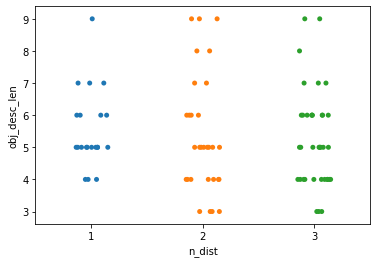

In [37]:
# distractor_cnt = []
# obj_desc_cnt = []
# spkr_msg_cnt = []
# g1 = sns.catplot(x="obj_desc_len", y="n_dist", data=data, orient="h")
# g1.set_axis_labels("Region description length", "Number of Distractor")
# g2 = sns.catplot(x="spkr_msg_len", y="n_dist", data=data, orient="h")
# g2.set_axis_labels("Speaker msg length", "Number of Distractor")

g1 = sns.stripplot(x="n_dist", y="obj_desc_len", data=data, jitter=0.15)
# g1.set_axis_labels("Region description length", "Number of Distractor
# data

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

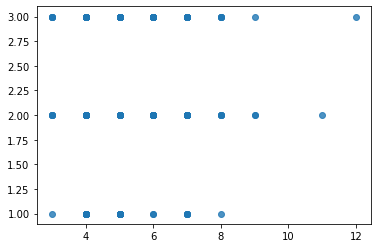